# P3HT Validation

In [1]:
import os

from cmeutils.structure import order_parameter
from fresnel import camera, pathtrace, light
from gixstapose.diffractometer import Diffractometer, get_angle
from gixstapose.draw_scene import get_scene
import gsd.hoomd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from planckton.utils.units import string_to_quantity, kelvin_from_reduced
from scipy.interpolate import RectBivariateSpline
import signac
import unyt as u

In the following notebook, we will demonstrate the recreation of part a of the following figure from [Miller 2018](http://www.mdpi.com/2073-4360/10/12/1305). This figure shows the order parameter of a OPLS-UA P3HT system at different temperatures and solvent parameters ($\epsilon_{s}$ or e_factor).

![Miller 2018 figure 3](images/Miller2018_fig3.png)

The order parameter is used to quantify the degree of ordering in the system by grouping structures into clusters, and then calculating the ratio of the structures in a "large" clusters over the total number of structures in the system.
In the case of a P3HT polymer, the structure we use for the order parameter analysis is the thiophene moeity. The clustering criteria depends on the angle between the planes of the thiophenes and the distance between the thiophene centers. A thiophene pair must meet both clustering criteria to be considered cluster neighbors. For example, if the angle cutoff is 10° and the distance cutoff is 6Å, the image below shows a thiophene pair which does not meet the criteria (encircled and crossed in red) and another which does (encircled in green).

![P3HT alignment](images/p3ht-alignment.png)

For a cluster to be considered "large", it must contain at least 6 thiophenes.

All of this analysis, from the simulations to the functions used to run the analysis itself has been redone using new tools. The goal is to show that not only can we recreate our previous work, but also the tools we've developed make this analysis more transparent, reproducible, usable, and extensible.

The dataset used in this notebook was generated using [PlanckTon](https://github.com/cmelab/planckton-flow), which provides a way to easily and reproducibly interface with the [HOOMD-blue](https://hoomd-blue.readthedocs.io/en/latest/index.html) molecular dynamics engine, and [PlanckTon-flow](https://github.com/cmelab/planckton-flow), which uses [Signac](https://docs.signac.io/en/latest/) to initialize and submit simulations across the desired parameter space. The workspace with all data used in this notebook can be found [here](https://zenodo.org/record/5911940).

First, assuming the tarball from the above link is unpacked in this directory, we can use signac to explore this workspace:

In [2]:
p = signac.get_project("p3ht-ua")

p.detect_schema()

ProjectSchema(<len=15>)

The above schema shows that we are looking at a dataspace of P3HT 16-mers, at a density of 0.56 $g/cm^{3}$ at 8 different temperatures and 5 different e_factors. In order to run the order parameter analysis, there is a little bookkeeping to be done with units.

PlanckTon runs its simulations in [reduced units](https://hoomd-blue.readthedocs.io/en/latest/units.html) to reduce floating point error. This means all lengths are scaled such that the largest sigma value in the non-bonded potential is equal to 1, and so on with the largest epsilon value in the non-bonded potential, and the largest particle mass.  

This information is stored in the [job document](https://docs.signac.io/en/latest/jobs.html#the-job-document) and can be converted to a [unyt quantity](https://unyt.readthedocs.io/en/stable/) using the `string_to_quantity` function.

In the cell below we set our angle and distance cutoffs for the order parameter analysis to 10° and 6Å scaled by the unit length of our simulation.

In [3]:
for job in p:
    if job.doc.get("done"):
        break
        
ref_energy = string_to_quantity(job.doc["ref_energy"])
ref_mass = string_to_quantity(job.doc["ref_mass"])
ref_distance = string_to_quantity(job.doc["ref_distance"])
print(f"{ref_distance:.3f} {ref_mass:.2e} {ref_energy:.3f}")

r_max = float(6 * u.Angstrom / ref_distance)
a_max = 10
print(f"r_max: {r_max:.2f}, a_max: {a_max}")

3.564 Å 5.32e-26 kg 0.250 kcal/mol
r_max: 1.68, a_max: 10


In the following cell, the order parameter analysis is performed over the entire workspace. Previously, this was done using [manual indexing and was hardcoded for our P3HT inputfiles](https://bitbucket.org/cmelab/evan_analysis_scripts/src/master/order_over_time.py). But this workflow has been updated to use [GRiTS](https://github.com/cmelab/grits) which uses [SMARTS](https://www.daylight.com/dayhtml/doc/theory/theory.smarts.html) chemical grammar to detect chemical patterns and map the particles in that pattern to a bead. The `order_parameter` function in [cmeutils](https://github.com/cmelab/cmeutils) then takes this mapping and the bead positions from GRiTS and calculates the order parameter of the last 10 frames of the trajectory.

In [4]:
%%time

o_dict = {}
orders = []
job_strs = []
ts = []
efs = []
keys = []
for (ef, kt), jobs in p.groupby(["e_factor", "kT"]):
    for job in jobs:
        if job.doc.get("done"):
            t_si = int(kelvin_from_reduced(kt[0],ref_energy))
            key = (ef, t_si)
            if key not in keys:
                gsdfile = job.fn("trajectory.gsd")
                cg_gsdfile = job.fn("cg-trajectory.gsd")
                mapfile = job.fn("mapping.json")
                if job.doc.get("order") is None:
                    if not (exists(mapfile) and exists(cg_gsdfile)):
                        system = CG_System(
                            gsdfile, 
                            beads={"_B" : "c1cscc1"}, 
                            conversion_dict=amber_dict,
                            add_hydrogens=True,
                        )
                        mapping = system.mapping["_B...c1cscc1"]
                        system.save_mapping(mapfile)
                        system.save(cg_gsdfile)
                        print("\tCG_System created")
                    else:
                        with open(mapfile) as f:
                            d = json.load(f)
                        mapping = np.stack(d["_B...c1cscc1"])
                        print("\tUsing mapping")
                    order, _ = order_parameter(gsdfile, cg_gsdfile, mapping, r_max, a_max)
                    order = np.mean(order)
                    job.doc["order"] = order
                else:
                    order = job.doc.order
                o_dict[key] = order
                orders.append(order)
                keys.append(key)
                ts.append(t_si)
                efs.append(ef)
                job_strs.append(str(job))

CPU times: user 29.8 ms, sys: 2.02 ms, total: 31.8 ms
Wall time: 29.7 ms


Next we will plot the order parameter vs T and e_factor using an [interpolating function from scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.RectBivariateSpline.html#scipy-interpolate-rectbivariatespline).

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive


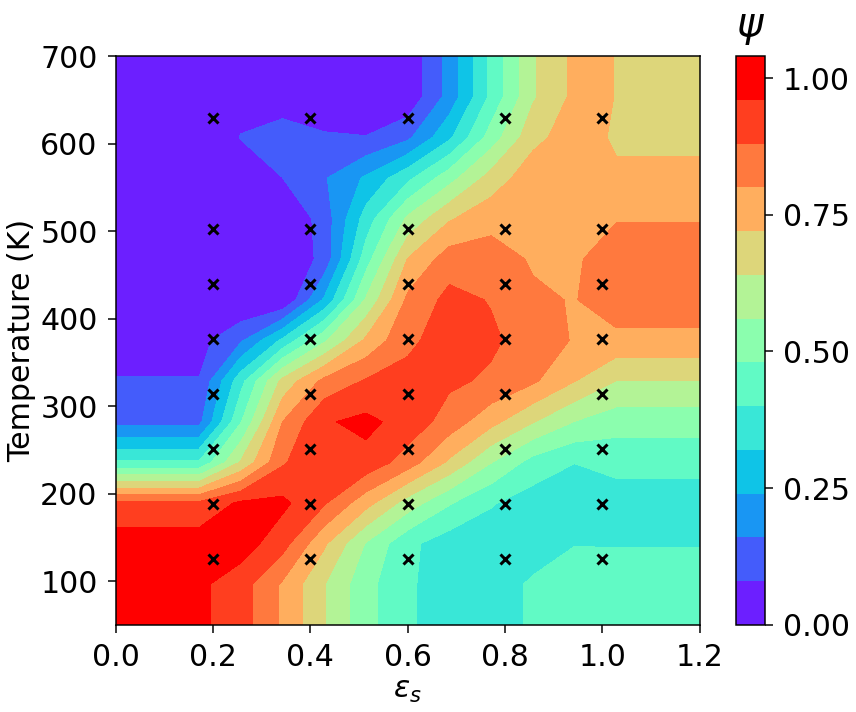

In [5]:
x = np.array(efs)
y = np.array(ts)
z = np.array(orders)

ux = np.unique(x)
uy = np.unique(y)
uz = np.zeros((len(uy),len(ux)))

# key = (ef, t_si)
for i, xi in enumerate(ux):
    for j, yj in enumerate(uy):
        uz[j,i] = o_dict[(xi, yj)]

f = RectBivariateSpline(uy,ux,uz)

xs = np.linspace(0, 1.2, 15)
ys = np.linspace(50, 700, 15)
zs = f(ys, xs)

zs[np.where(zs > 1)] = 1
zs[np.where(zs < 0)] = 0

plt.contourf(xs, ys, zs, 15, cmap="rainbow", vmax=1, vmin=0)

cbar = plt.colorbar(ticks=np.linspace(0, 1, 5, endpoint=True))
cbar.ax.set_title(r"$\psi$", fontsize=40, pad=20)

# Show the positions of the sample points, just to have some reference
plt.scatter(x, y, c="k", marker="x", s=100)
plt.xlabel(r"$\epsilon_{s}$")
plt.ylabel("Temperature (K)")
plt.xticks(np.linspace(0, 1.2, 7))
fig = plt.gcf()
fig.set_size_inches(12, 10)
plt.savefig("order_parameter.pdf")

Even with the changes to our analysis method (using GRiTS instead of manual indexing), the forcefield (using GAFF instead of OPLS), and the clustering criteria (10° instead of 20°), the trend in the order parameter across temperature and e_factor space appears pretty robust! I have included only part a from Miller 2018 below with the plot skewed so that the bounds are the same.

![Miller 2018 figure 3 part a adjusted](images/Miller2018_fig3_aonly.png)

We can show that our order parameter metric is robust, but how does it relate to any physically measurable analysis? To address this question, let's look at some diffraction patterns for the highest and lowest order jobs to see if our order parameter metric is correlated with differences in the periodic structure. We'll be using [GIXStapose](https://github.com/cmelab/GIXStapose) to visualize the real space structrue and it's diffraction pattern.

In [6]:
highest_order_jobs = [job_strs[orders.index(i)] for i in sorted(orders)[-3:]]
lowest_order_jobs = [job_strs[orders.index(i)] for i in sorted(orders)[:4]]

print("Higest order")
for job_id in highest_order_jobs:
    job = p.open_job(id=job_id)
    T_SI = int(kelvin_from_reduced(job.sp.kT[0],ref_energy))
    print(f"e_factor: {job.sp.e_factor}, T: {T_SI}K")
    print(f"\t{job}")
    
print("\n\nLowest order")
for job_id in lowest_order_jobs:
    job = p.open_job(id=job_id)
    T_SI = int(kelvin_from_reduced(job.sp.kT[0],ref_energy))
    print(f"e_factor: {job.sp.e_factor}, T: {T_SI}K")
    print(f"\t{job}")

Higest order
e_factor: 0.4, T: 188K
	6289cb58ab91a927f702b7cf238820aa
e_factor: 0.4, T: 251K
	16db9573e2e2c6a027abad40cf87733e
e_factor: 0.2, T: 125K
	c1e543f38d9f49677b3e3649018152b8


Lowest order
e_factor: 0.2, T: 629K
	c0fd30e6247f95e9c26984ec5f24d99e
e_factor: 0.4, T: 629K
	e8e42f76f02e02e686332ce8127e1b24
e_factor: 0.2, T: 503K
	349a22231886a7a46aeb7f20c95204e0
e_factor: 0.6, T: 629K
	d2da0d6355f3d11fd0132bcf8433df7e


First let's look at one of the high order jobs (e_factor: 0.4, T: 251K). We'll first visualize the centers of the thiophenes. (It is a little less busy than the atomistic sturcture and allows us to more easily see the lamellar spacing.)

The camera position was chosen using the GIXStapose GUI to rotate the structure as to best see the lamellae.

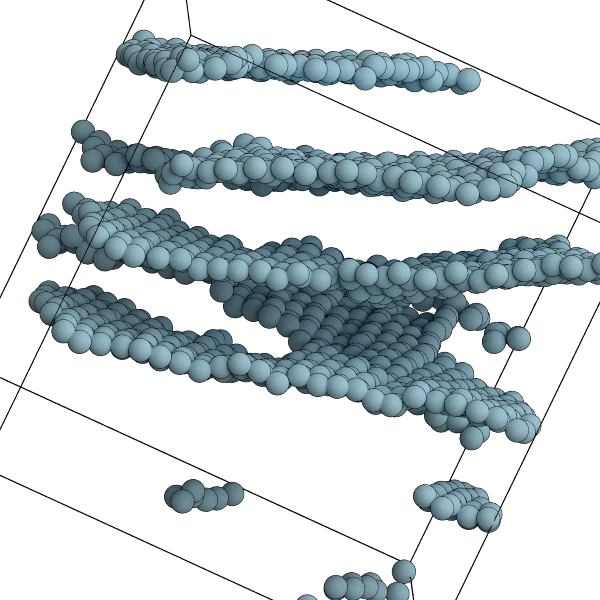

In [7]:
job = p.open_job(id='16db9573e2e2c6a027abad40cf87733e')
cg_gsd = job.fn("cg-trajectory.gsd")
scene, info = get_scene(cg_gsd, color={"_B": "lightblue"}, scale=ref_distance)
cam = camera.Orthographic(
    position = [8.133, 5.203, 43.865],
    look_at =  [0.000, 0.000, 0.000],
    up =       [0.900, 0.424, -0.101],
    height =   31.896
)
scene.camera = cam

scene.geometry[0].radius[:] *= 3

output = pathtrace(scene, light_samples=40, w=600, h=600)

image = Image.fromarray(output[:], mode="RGBA")
image.save("cg-trajectory_scene.png")

output

We can see that this high order structure has clear repeated planes of thiophenes, even within these planes there appears to be some ordering most likely due to pi orbital overlap in the thiophenes. Let's look at the diffraction pattern of this view:

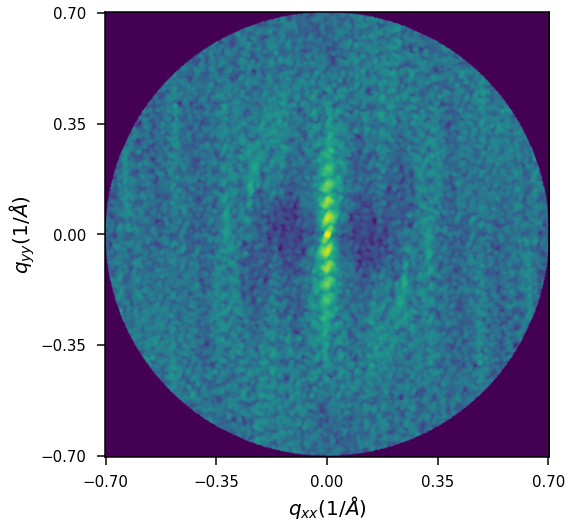

In [8]:
d = Diffractometer(length_scale=float(ref_distance))
d.load(info["positions"], info["box"][:3])
d.diffract_from_camera(cam)
d.plot()
plt.show()

In this view, we can see bright peaks in the $q_{yy}$-direction corresponding to the lamellar spacing. The pi-stacking can also faintly be seen in the $q_{xx}$-direction.

In the next cell, we'll visualize the overlay of the coarse grain structure with the atomistic one:

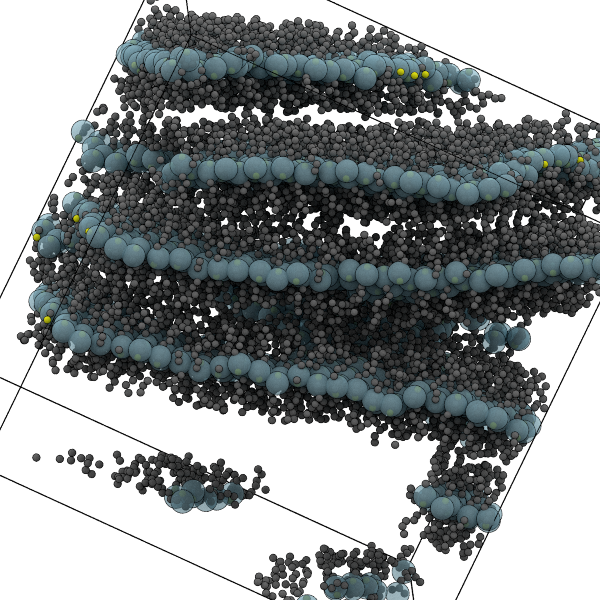

In [9]:
aa_gsd = job.fn("trajectory.gsd")
aa_scene, _ = get_scene(
    aa_gsd, 
    color={'c3': "grey", 'cc': "grey", 'cd': "grey", 'ss': "yellow"}, 
    scale=ref_distance,
    scene=scene
)

aa_scene.camera = cam

aa_scene.geometry[0].material.spec_trans = 0.5

aa_scene.lights = light.cloudy()

output = pathtrace(aa_scene, light_samples=40, w=600, h=600)

image = Image.fromarray(output[:], mode="RGBA")
image.save("cg-overlay_scene.png")

output

When we view this overlay (thiophene center beads show in translucent blue, atomistic carbons in grey and sulfur in yellow), it becomes more clear that this lamellar spacing is due to the regions with the alkyl tails interacting.

Finally let's look at one of the low order jobs (e_factor: 0.2, T: 629K):

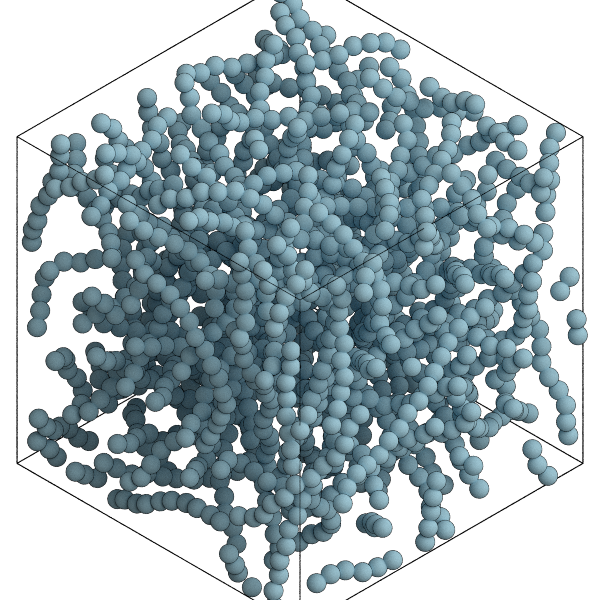

In [10]:
job = p.open_job(id='c0fd30e6247f95e9c26984ec5f24d99e')
cg_gsd = job.fn("cg-trajectory.gsd")
scene, info = get_scene(cg_gsd, color={"_B": "lightblue"}, scale=ref_distance)

scene.geometry[0].radius[:] *= 3

output = pathtrace(scene, light_samples=40, w=600, h=600)

image = Image.fromarray(output[:], mode="RGBA")
image.save("cg-trajectory-amorphous_scene.png")

output

This view shows that the packing looks basically random.

And we can confirm this by examing the diffraction pattern:

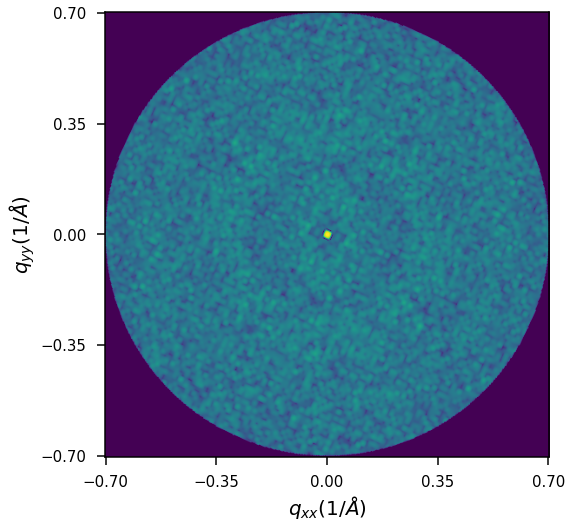

In [11]:
d = Diffractometer(length_scale=float(ref_distance))
d.load(info["positions"], info["box"][:3])
d.diffract_from_camera(cam)
d.plot()
plt.show()

The general lack of peaks suggests that there are few periodic features to be found.

In conclusion, this analysis has shown that we can reproduce our prior work with updated tools, the order parameter metric is robust across different forcefields and relates to the prominence of peaks in the diffraction pattern.